# Inference on 2 parameters with real data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dap import DAPcython
from dap.dap_sumstats_moments import DAPSummaryStatsMoments
from dap.dap_simulator import DAPSimulator
from dap.utils import obs_params_gbar, syn_current, syn_obs_stats, syn_obs_data
from dap.cell_fitting.read_heka import (get_sweep_index_for_amp, get_i_inj_from_function,
                                    get_v_and_t_from_heka, shift_v_rest, get_i_inj_zap)

In [2]:
from delfi.distribution import Uniform
from delfi.generator import Default
from delfi.inference import SNPE  # , Basic, CDELFI

In [3]:
# General Settings Pick
n_rounds = 1
n_summary = 17
n_samples = 1000
n_hiddens = [15, 15]
n_components = 1
reg_lambda = 0.01

## Load the currents

In [4]:
def load_current(data_dir, protocol='rampIV', ramp_amp=3.1, disc=True):
    '''
    ramp_amp:  optimal=3.1, steps of 0.05 -0.15
    protocol: 'rampIV', 'IV', 'Zap20'

    '''
    v_shift = -16  # shift for accounting for the liquid junction potential

    if protocol == 'Zap20':
        sweep_idx = 0
    else:
        sweep_idx = get_sweep_index_for_amp(ramp_amp, protocol)

    v, t = get_v_and_t_from_heka(data_dir, protocol, sweep_idxs=[sweep_idx])
    v = shift_v_rest(v[0], v_shift)
    t = t[0]
    dt = t[1] - t[0]

    I, t_on, t_off = get_i_inj_from_function(protocol, [sweep_idx], t[-1], dt,
                                              return_discontinuities=disc)
    I = I[0]

    return I, v, t, dt, t_on, t_off

In [5]:
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'  # best cell
# data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_11d.dat'  # second best cell

In [6]:
# load the data
I_iv, v_iv, t_iv, dt_iv, t_on_iv, t_off_ic = load_current(data_dir, protocol='IV', ramp_amp=1, disc=False)

In [7]:
I, v, t, dt, t_on, t_off = load_current(data_dir, protocol='rampIV', ramp_amp=3.1, disc=False)

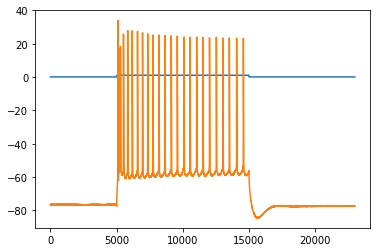

In [8]:
# IV
plt.plot(I_iv)
plt.plot(v_iv);

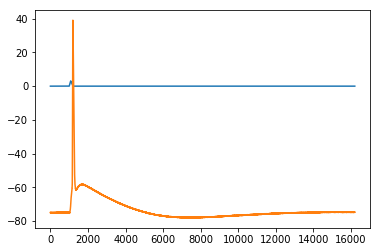

In [9]:
# rampIV
plt.plot(I)
plt.plot(v);

## Setup the DAP model

In [10]:
# load needed parameters
params, labels = obs_params_gbar(reduced_model=True)

# Set up the model
dap = DAPcython(-75, params*10)
U = dap.simulate(dt, t, I)

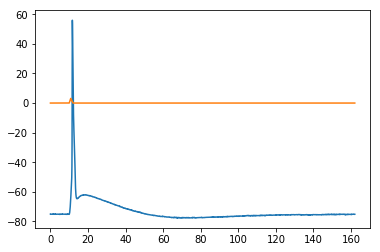

In [11]:
plt.plot(t, U)
plt.plot(t, I);

In [12]:
# generate data format for SNPE / OBSERVABLE
x_o = {'data': v.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}

## Setup Simulation

In [13]:
# Setup Priors
prior_min = np.array([0, 0])
prior_max = np.array([2, 2])
prior_unif = Uniform(lower=prior_min, upper=prior_max)

In [14]:
# Summary Statistics
S = syn_obs_stats(x_o['I'], params=params, dt=x_o['dt'], t_on=t_on, t_off=t_off,
                  n_summary=n_summary, summary_stats=2, data=x_o)

In [15]:
M = DAPSimulator(x_o['I'], x_o['dt'], -75)
s = DAPSummaryStatsMoments(t_on, t_off, n_summary=n_summary)
G = Default(model=M, prior=prior_unif, summary=s)  # Generator

In [16]:
# Runing the simulation
inf_snpe = SNPE(generator=G, n_components=n_components, n_hiddens=n_hiddens, obs=S,
                reg_lambda=reg_lambda, pilot_samples=0, verbose=True)

In [17]:
logs, tds, posteriors = inf_snpe.run(n_train=[n_samples], n_rounds=n_rounds,
                                     proposal=prior_unif)


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]



observed [[-7.49345000e+01  4.90326342e-02 -7.31867130e+01  1.00000000e+00
   5.14765140e-01  4.24078081e-01  4.36389861e-01  4.30392646e-01
   1.31175595e+03  1.03064612e+00  2.65280566e+00  4.78391503e+00
   4.06115478e+01  1.02643909e+00  2.59149132e+00  4.65716613e+00]]


## Analyse results

In [18]:
samples_prior = prior_unif.gen(n_samples=int(5e5))
samples_posterior = posteriors[-1].gen(n_samples=int(5e5))

print('posterior:', posteriors[-1].mean)


x_post = syn_obs_data(I, dt, posteriors[-1].mean)
idx = np.arange(0, len(x_o['data']))
rmse = np.linalg.norm(x_o['data'] - x_post['data']) / len(x_o['data'])

print('RMSE:', rmse)

posterior: [0.15519872 0.84489828]
RMSE: 0.033539961841460623


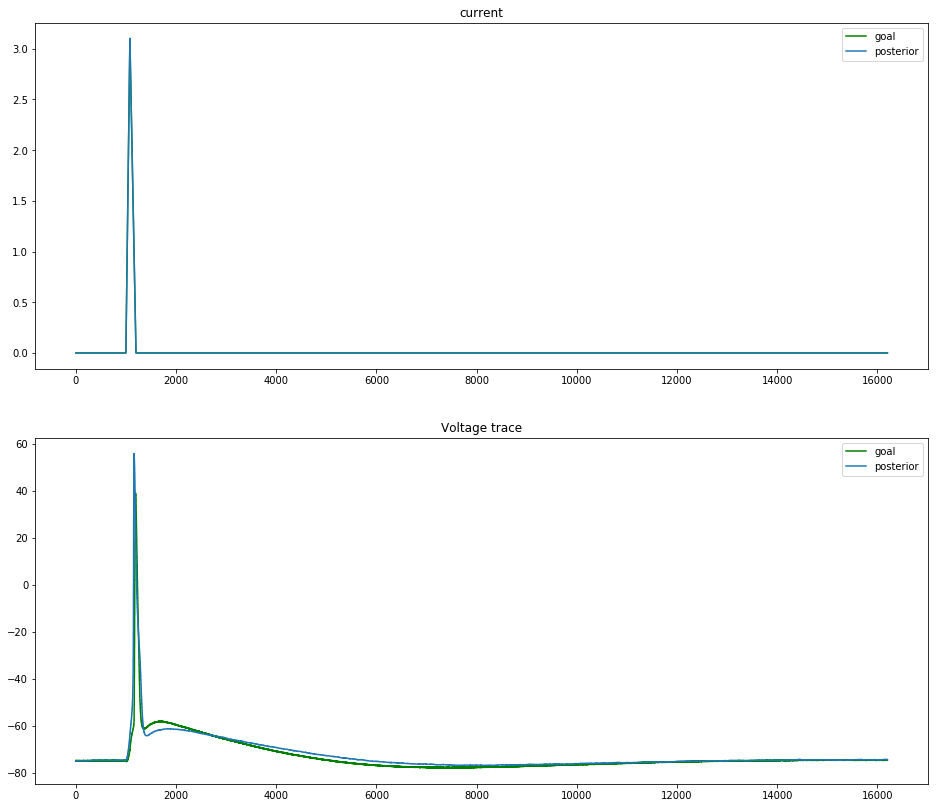

In [19]:
simulation, axes = plt.subplots(2, 1, figsize=(16,14))
axes[0].plot(idx, x_o['I'], c='g', label='goal')
axes[0].plot(idx, x_post['I'], label='posterior')
axes[0].set_title('current')
axes[0].legend()

axes[1].step(idx, x_o['data'], c='g', label='goal')
axes[1].step(idx, x_post['data'], label='posterior')
axes[1].set_title('Voltage trace')
axes[1].legend()

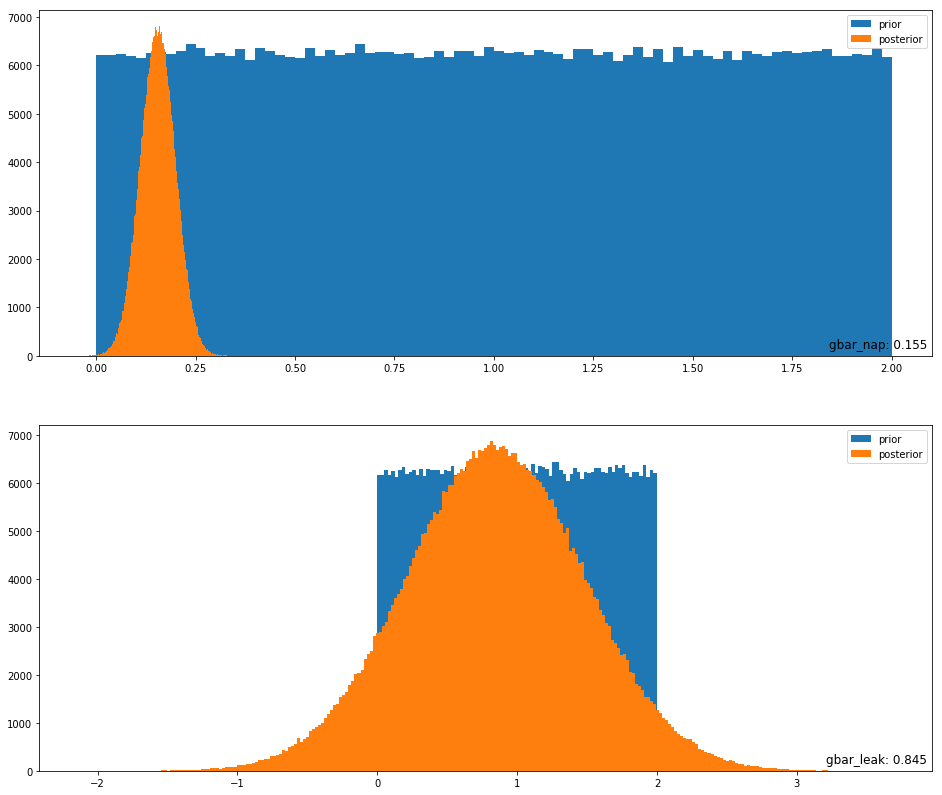

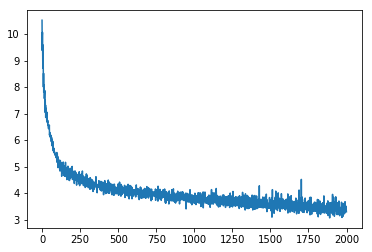

In [20]:
distr_comb, axes = plt.subplots(2, 1, figsize=(16, 14))
axes[0].hist(samples_prior[:, 0], bins='auto', label='prior')
axes[1].hist(samples_prior[:, 1], bins='auto', label='prior')
axes[0].hist(samples_posterior[:, 0], bins='auto', label='posterior')
axes[1].hist(samples_posterior[:, 1], bins='auto', label='posterior')
axes[0].legend()
axes[1].legend()

axes[0].annotate(labels[0]+': '+str(round(posteriors[-1].mean[0], 3)),
                   xy=(1, 0), xycoords='axes fraction', fontsize=12,
                   xytext=(-5, 5), textcoords='offset points',
                   ha='right', va='bottom')
axes[1].annotate(labels[1]+': '+str(round(posteriors[-1].mean[1], 3)),
                   xy=(1, 0), xycoords='axes fraction', fontsize=12,
                   xytext=(-5, 5), textcoords='offset points',
                   ha='right', va='bottom')

plt.figure()
plt.plot(logs[0]['loss'])

In [22]:
params_post = posteriors[-1].mean
dap_new = DAPcython(-75, params*10)
U = dap_new.simulate(dt, t, I)
U_iv = dap_new.simulate(dt, t, I_iv)

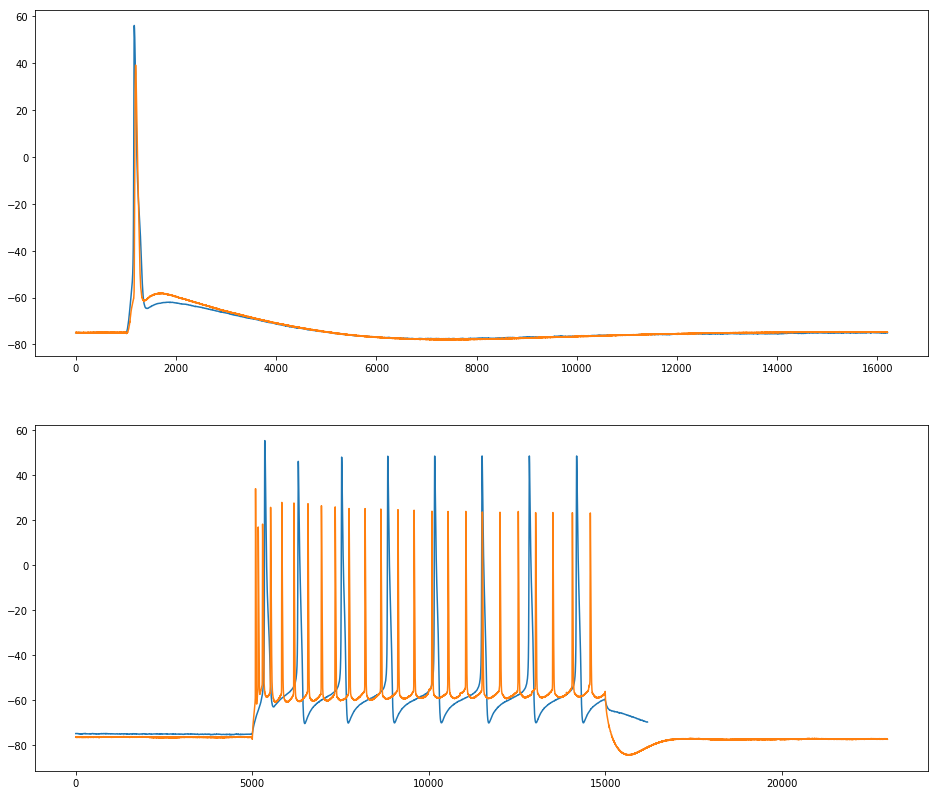

In [25]:
f, ax = plt.subplots(2,1, figsize=(16, 14))
ax[0].plot(U)
ax[0].plot(v)
ax[1].plot(U_iv);
ax[1].plot(v_iv);